In [103]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import seaborn
from sklearn.model_selection import GridSearchCV, train_test_split
import pandas as pd
seaborn.set()
data = pd.read_csv("data/train_data.csv")


# date = '2022-02-07'
# train, test = data.ScheduleTime < date,  data.ScheduleTime >= date

date = '2022-01-14'
train, test = data.ScheduleTime < date,  data.ScheduleTime >= date
val_, test_ = train_test_split(test[test == 1], random_state = 0, test_size = 0.5)
test.loc[test_.index] = False
train.loc[val_.index] = True

X_train = data[train].drop(["ScheduleTime", "LoadFactor"], axis = 1)
y_train = data[train].LoadFactor.values


X_test  = data[test].drop(["ScheduleTime", "LoadFactor"], axis = 1)
y_test  = data[test].LoadFactor.values

SeatCapacity = X_test.SeatCapacity.values
X_test

,SeatCapacity,Hour,Weekday,High_Season,Corona,Airline_5M,Airline_AP,Airline_AY,Airline_BJ,Airline_BT,...,US_Holiday_Juneteenth National Independence Day,US_Holiday_Juneteenth National Independence Day (Observed),US_Holiday_Labor Day,US_Holiday_Martin Luther King Jr. Day,US_Holiday_Memorial Day,US_Holiday_New Year's Day,US_Holiday_New Year's Day (Observed),US_Holiday_Thanksgiving,US_Holiday_Veterans Day,US_Holiday_Washington's Birthday
35838,174,4,0,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35839,180,6,0,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35840,180,7,0,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35841,76,7,0,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35842,180,7,0,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39444,144,18,0,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39445,156,19,0,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39446,98,20,0,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39447,186,19,0,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
Forest  = RandomForestRegressor(n_estimators = 25, min_samples_leaf = 3, max_features = 75, n_jobs= -1)
Booster = GradientBoostingRegressor(n_estimators = 600, max_depth = 7, learning_rate = 0.065071, max_features = 200, subsample = .5)

Forest.fit(X_train, y_train)
# Booster.fit(X_train, y_train)


RandomForestRegressor(max_features=75, min_samples_leaf=3, n_estimators=25,
                      n_jobs=-1)

# Random Forest 

In [86]:
N = 5000

In [107]:
y_hat = Forest.predict(X_test)

M = len(y_test)

Bootstrap_idx = np.random.choice(np.arange(M), (M, 1000), replace=True)

MSE_bootstrap = pow(y_hat[Bootstrap_idx] - y_test[Bootstrap_idx],2).mean(0)
Forest_MSE = MSE_bootstrap.mean()
Forest_MSE_CI  = np.quantile(MSE_bootstrap, q = [0.025, 0.975])
print(f"Mean Squared Error (Test): {round(Forest_MSE,5)}")
print(f"Bootstrapped CI's MSE (Test): {np.round(Forest_MSE_CI,5)}")


Mean Squared Error (Test): 0.03623
Bootstrapped CI's MSE (Test): [0.03438 0.0381 ]


In [108]:
y_hat_no_zero = y_hat[y_test != 0]
y_test_no_zero = y_test[y_test != 0]


M = len(y_test_no_zero)

Bootstrap_idx = np.random.choice(np.arange(M), (M, 1000), replace=True)

ActualPassengers    = SeatCapacity[y_test != 0] * y_test_no_zero
PredictedPassengers = SeatCapacity[y_test != 0] * y_hat_no_zero 

PassengerScore_bootstrap = (1 - abs((ActualPassengers[Bootstrap_idx] - PredictedPassengers[Bootstrap_idx]) / (ActualPassengers[Bootstrap_idx]))).mean(axis = 0)
Forest_PassengerScore           = PassengerScore_bootstrap.mean()

Forest_PassengerScore_CI = np.quantile(PassengerScore_bootstrap, [0.025, 0.975])
print(f"Passenger Deviance (Test): {round(Forest_PassengerScore,5)}")
print(f"Bootstrapped CI's Passeneger Deviance (Test): {np.round(Forest_PassengerScore_CI,5)}")

Passenger Deviance (Test): 0.63405
Bootstrapped CI's Passeneger Deviance (Test): [0.60892 0.65609]


In [109]:
abs((ActualPassengers - PredictedPassengers)/ActualPassengers).mean()


0.3657879022645083

# Gradient Booster

In [97]:
y_hat = Booster.predict(X_test)

M = len(y_test)


Bootstrap_idx = np.random.choice(np.arange(M), (M, 1000), replace=True)

MSE_bootstrap = pow(y_hat[Bootstrap_idx] - y_test[Bootstrap_idx],2).mean(0)
Booster_MSE = MSE_bootstrap.mean()
Booster_MSE_CI  = np.quantile(MSE_bootstrap, q = [0.025, 0.975])
print(f"Mean Squared Error (Test): {round(Booster_MSE,5)}")
print(f"Bootstrapped CI's MSE (Test): {np.round(Booster_MSE_CI,5)}")


Mean Squared Error (Test): 0.03711
Bootstrapped CI's MSE (Test): [0.03534 0.03894]


In [98]:
y_hat_no_zero = y_hat[y_test != 0]
y_test_no_zero = y_test[y_test != 0]


M = len(y_test_no_zero)


Bootstrap_idx = np.random.choice(np.arange(M), (M, 1000), replace=True)

ActualPassengers    = SeatCapacity[y_test != 0] * y_test_no_zero
PredictedPassengers = SeatCapacity[y_test != 0] * y_hat_no_zero 

PassengerScore_bootstrap = (1 - abs((ActualPassengers[Bootstrap_idx] - PredictedPassengers[Bootstrap_idx]) / (ActualPassengers[Bootstrap_idx]))).mean(axis = 0)
Booster_PassengerScore           = PassengerScore_bootstrap.mean()

Booster_PassengerScore_CI = np.quantile(PassengerScore_bootstrap, [0.025, 0.975])
print(f"Passenger Deviance (Test): {round(Booster_PassengerScore,5)}")
print(f"Bootstrapped CI's Passeneger Deviance (Test): {np.round(Booster_PassengerScore_CI,5)}")


Passenger Deviance (Test): 0.632
Bootstrapped CI's Passeneger Deviance (Test): [0.60544 0.65625]


In [101]:
abs((ActualPassengers - PredictedPassengers)/ActualPassengers).mean()

0.36740176343920733

# Plots

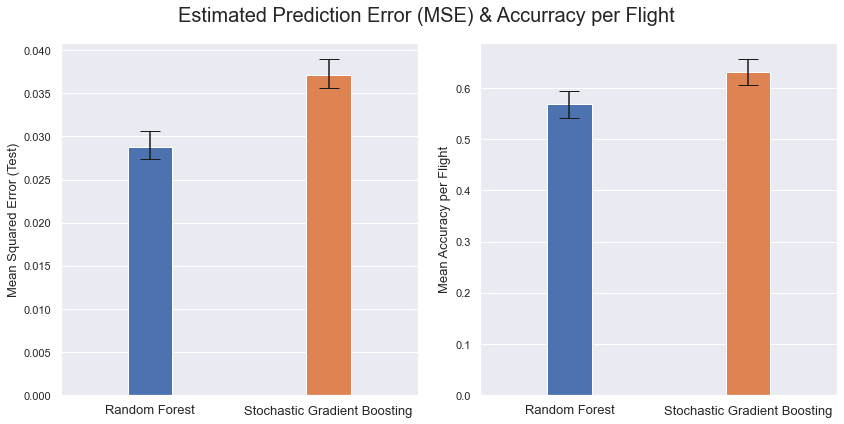

In [99]:
fig, ax = plt.subplots(1,2, figsize = (12,6))

ax[0].bar([-0.2, 0.2], [Forest_MSE, Booster_MSE],
         width = 0.1,
         color = ['C0', 'C1'],
         capsize = 10,
         yerr = np.array([abs(Forest_MSE - Forest_MSE_CI), abs(Booster_MSE - Booster_MSE_CI)]));

ax[0].set_xlim(-0.4, 0.4)
ax[0].set_xticks([-0.2, 0.2])
ax[0].set_xticklabels(["Random Forest", "Stochastic Gradient Boosting"], fontsize = 13)
ax[0].set_ylabel("Mean Squared Error (Test)", fontsize = 13)
ax[0].xaxis.grid(False)

ax[1].bar([-0.2, 0.2], [Forest_PassengerScore, Booster_PassengerScore],
         width = 0.1,
         color = ['C0', 'C1'],
         capsize = 10,
         yerr = np.array([abs(Forest_PassengerScore - Forest_PassengerScore_CI), abs(Booster_PassengerScore - Booster_PassengerScore_CI)]));
ax[1].set_xlim(-0.4, 0.4)
ax[1].set_xticks([-0.2, 0.2])
ax[1].set_xticklabels(["Random Forest", "Stochastic Gradient Boosting"],  fontsize = 13)
ax[1].set_ylabel("Mean Accuracy per Flight", fontsize = 13)
ax[1].xaxis.grid(False)
fig.suptitle("Estimated Prediction Error (MSE) & Accurracy per Flight", fontsize = 20)
fig.tight_layout()


# Predictions

In [32]:
final_model = GradientBoostingRegressor(n_estimators = 900, max_depth = 7, learning_rate = 0.022357, max_features = 10)

X = data.drop(["ScheduleTime","LoadFactor"], axis = 1)
y = data.LoadFactor

X.columns.shape

# final_model.fit(X,y)


(436,)

In [33]:
X_test = pd.read_csv("data/test_data.csv").drop(["ScheduleTime"], axis = 1)
LoadFactor = final_model.predict(X_test)

future_schedule = pd.read_excel('data/Future Schedule.xlsx')
future_schedule["LoadFactor"] = LoadFactor
future_schedule.to_csv("results/output.txt", index = False)
future_schedule

c:\Users\peter\OneDrive - Danmarks Tekniske Universitet\DTU\8. Semester\02582-Computational_Data_Analysis\env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


NotFittedError: This GradientBoostingRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

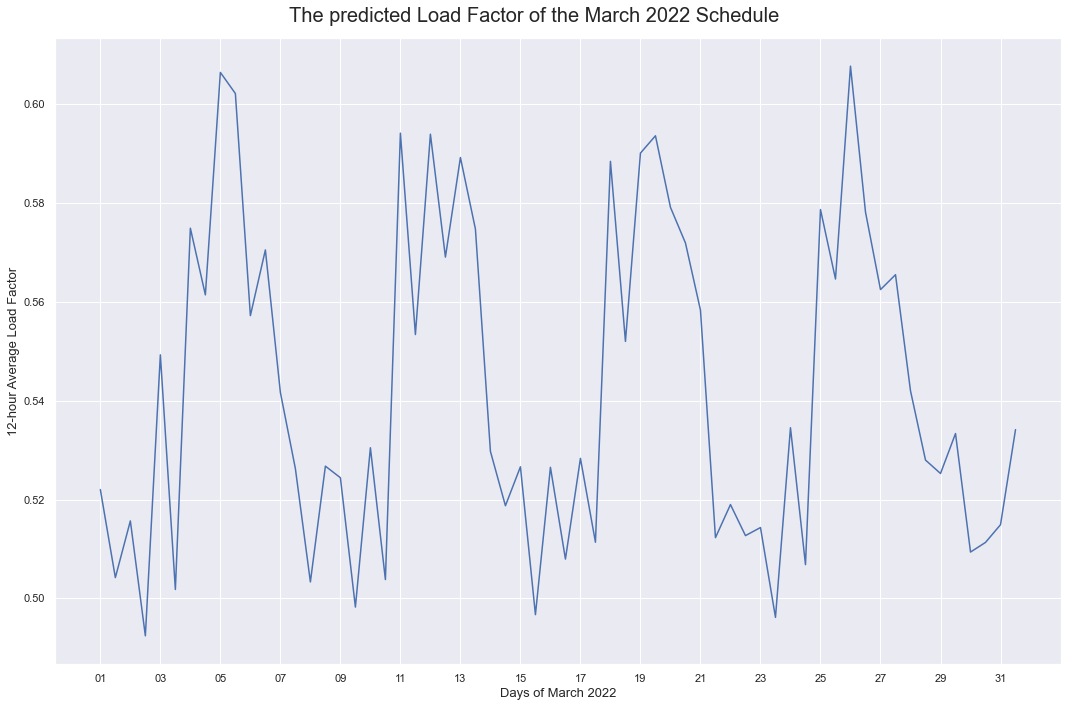

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
DailyLoad = future_schedule.set_index('ScheduleTime').resample('12h').mean()
# DailyLoad.LoadFactor.plot(ax = ax, );
ax.plot(DailyLoad.index, DailyLoad.LoadFactor)
ax.set_xticks(DailyLoad.index[::4])
ax.set_xticklabels(DailyLoad.reset_index().ScheduleTime[::4].apply(lambda x: x.strftime('%d')));
ax.set_xlabel("Days of March 2022", fontsize = 13)
ax.set_ylabel("12-hour Average Load Factor", fontsize = 13);
fig.suptitle("The predicted Load Factor of the March 2022 Schedule", fontsize = 20);
fig.tight_layout()
